Classifying Spectra with Convolutional Neural Networks (CNNs)
===



Author: Nathan A. Mahynski
    
Date: 2024/08/02
    
Description: Examples of how to classify 1D spectra and 2D "images" using explainable CNNs.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/cnn_spectral_classification.ipynb)

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [2]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import watermark
import shap
import keras

import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from pyts.image import GramianAngularField
from pychemauth import utils
from pychemauth.datasets import make_pgaa_images, load_pgaa
from pychemauth.classifier.cnn import CNNFactory
from pychemauth.analysis.explain import CAM2D, color_series, bokeh_color_spectrum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%load_ext watermark

%load_ext autoreload
%autoreload 2

2024-08-06 10:10:06.826974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 10:10:06.869350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 10:10:06.869404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 10:10:06.869443: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 10:10:06.877999: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 10:10:06.878927: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.26.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 6.5.0-45-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

watermark : 2.4.3
json      : 2.0.9
shap      : 0.45.1
numpy     : 1.24.3
matplotlib: 3.7.2
keras     : 2.14.0
pychemauth: 0.0.0b4



1D CNN
---

Load Data
***

In [4]:
# Let's look at the data over this range of bins.
valid_range=(0, 2631)

In [5]:
# Load the dataset, clip, then renormalize
X, y = load_pgaa(return_X_y=True)
X = X[:, valid_range[0] : valid_range[1]]
X = (X.T / np.sum(X, axis=1)).T
X = np.log(np.clip(X, a_min=1.0e-7, a_max=None))

# Also convert X into a "single channeled image" with shape (2631, 2631, 1)
X = np.expand_dims(X, axis=-1)

# Exclude minor components - these have < 10 observations in the dataset
mask = np.array([False]*X.shape[0])
for class_ in ['Carbon Powder', 'Phosphate Rock', 'Zircaloy']:
    mask = mask | (y == class_)
X = X[~mask]
y = y[~mask]

# Split into test/train sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y,
)

# Convert classes from strings to integers
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Record some basic properties about this revised dataset
image_size = (valid_range[1]-valid_range[0], 1)
n_classes = len(np.unique(y))

In [6]:
# Let's write the dataset to disk so we can create data iterators later on
from pychemauth.utils import write_dataset
_ = write_dataset('./1d-dataset/train', X_train, y_train, overwrite=True, augment=False)
_ = write_dataset('./1d-dataset/test', X_test, y_test, overwrite=True, augment=False)

Learning Rate Finder
***

In [7]:
def make_model(image_size, n_classes, activation='relu'):
    input_ = keras.layers.Input(shape=image_size)
    conv1 = layers.Conv1D(filters=16, kernel_size=16, activation=activation, strides=8, padding='same', use_bias=True)(input_)
    pool1 = layers.MaxPool1D(2)(conv1)
    conv2 = layers.Conv1D(filters=16*8, kernel_size=8, activation=activation, strides=4, padding='same', use_bias=True)(pool1)
    pool2 = layers.MaxPool1D(2)(conv2)
    conv3 = layers.Conv1D(filters=16*8*4, kernel_size=8, activation=activation, strides=2, padding='same', use_bias=True)(pool2)
    flat = layers.Flatten()(conv3)
    output = layers.Dense(n_classes, activation='softmax')(flat)
    model = keras.Model(inputs=[input_], outputs=[output])
    
    return model

2024-08-05 15:29:36.585133: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/nam4/anaconda3/envs/k3test/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


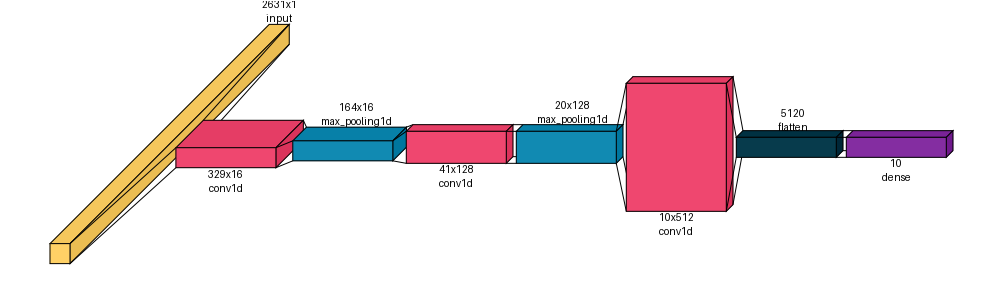

In [8]:
utils.NNTools.visualkeras(make_model(image_size, n_classes=n_classes, activation='elu'), max_z=100)

In [9]:
data_loader = utils.NNTools.build_loader('./1d-dataset/train', batch_size=100, shuffle=True)
finder = utils.NNTools.find_learning_rate(
    make_model(image_size, n_classes=n_classes, activation='elu'),
    data_loader,
    start_lr=1.0e-6,
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


1/1 [==============================] - 0s 461ms/step
Epoch 1/42
3/3 [==============================] - 2s 41ms/step - loss: 2.7131 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 2/42
3/3 [==============================] - 0s 45ms/step - loss: 2.6818 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000 
Epoch 3/42
3/3 [==============================] - 0s 33ms/step - loss: 2.6419 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 4/42
3/3 [==============================] - 0s 33ms/step - loss: 2.5817 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 5/42
3/3 [==============================] - 0s 39ms/step - loss: 2.5089 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 6/42
3/3 [==============================] - 0s 41ms/step - loss: 2.4151 - accuracy: 0.0818 - sparse_categorical_accuracy: 0.0818
Epoch 7/42
3/3 [==============================] - 0s 36ms/step - loss: 2.3486 - accuracy: 0.1010 - sparse_categorical_accuracy: 0.1010
E

In [10]:
# Observe that x and y are shuffled
data_loader.x[:3]

['/home/nam4/Documents/1d-dataset/train/x_000000223.npy',
 '/home/nam4/Documents/1d-dataset/train/x_000000000.npy',
 '/home/nam4/Documents/1d-dataset/train/x_000000061.npy']

In [11]:
# Compare the data loader's first 3 y values...
data_loader.y[:3]

array([6, 7, 7])

In [12]:
# ... to the original y with indices corresponding to the x files.
y_train[223], y_train[0], y_train[61]

(6, 7, 7)

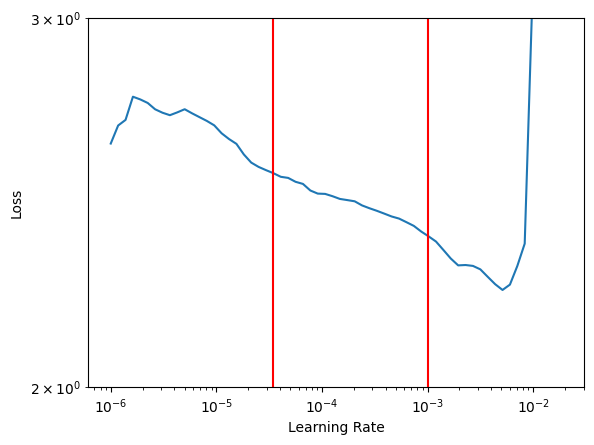

In [13]:
# Let's see if we can establish a reasoble range of learning rates so we can use cyclical learning rates when training
ax = finder.plot()
ax.set_yscale('log')

frac = 0.5

ax.set_ylim(2, 3)
for l_ in finder.estimate_clr(frac=frac):
    ax.axvline(l_, color='red')

Cyclical Learning Rates
***

In [14]:
def fit_model(image_size, finder, n_classes, use_clr=False, wandb_project=None, mode='triangular'):
    """Convenient function to train models several times with different hyperparameters."""
    clr = utils.NNTools.CyclicalLearningRate(
        base_lr=finder.estimate_clr(frac=frac)[0],
        max_lr=finder.estimate_clr(frac=frac)[1],
        step_size=10, # 1/2 cycle every 10 epochs
        mode=mode,
    )

    # Build a fresh model
    model = make_model(image_size, n_classes=n_classes, activation='relu')

    # Build a data loader
    data_loader = NNTools.build_loader('./1d-dataset/train', batch_size=100, shuffle=True)
    
    # Do the training
    model = utils.NNTools.train(
        model=model,
        data=data_loader, 
        fit_kwargs={
            'epochs': 60, # (10*2) = 20 epochs for a cycle, so this is 3 cycles
            'validation_data': NNTools.build_loader('./1d-dataset/test', batch_size=100), # Shuffling doesn't matter here
            'callbacks': [clr] if use_clr else []
        },
        model_filename=None, # Do not save locally
        history_filename=None, # Do not save locally
        wandb_project=wandb_project,
        seed=42
    )
    
    return model, clr, data_loader

def plot_results(model, clr=None):
    """Convenient function to plot results locally - you can see the same results on WandB."""
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

    for ax in axes:
        ax.set_xlabel('Epoch')
    
    if clr is not None:
        axes[0].plot(
            clr.history['iterations'],
            clr.history['lr']
        )
    else:
        axes[0].axhline(float(model.optimizer.lr))
    axes[0].set_ylabel('Learning Rate')
    axes[0].set_yscale('log')

    axes[1].plot(model.history.history['accuracy'], label='Accuracy')
    axes[1].plot(model.history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='best')

    axes[2].plot(model.history.history['loss'], label='Loss')
    axes[2].plot(model.history.history['val_loss'], label='Validation Loss')
    axes[2].set_ylabel('Loss')
    axes[2].legend(loc='best')

In [15]:
# Let's try several different CLR strategies to compare them.
# Visit wandb.com to look at the new runs stored in the 'cnn-1d-demo' project!
model_none, _, dl_none = fit_model(
    image_size, 
    finder, 
    n_classes=n_classes, 
    use_clr=False, 
    wandb_project='cnn-1d-demo'
)

model_clr, clr, dl = fit_model(
    image_size, 
    finder, 
    n_classes=n_classes, 
    use_clr=True, 
    wandb_project='cnn-1d-demo', 
    mode='triangular'
)

model_clr2, clr2, dl2 = fit_model(
    image_size, 
    finder, 
    n_classes=n_classes, 
    use_clr=True, 
    wandb_project='cnn-1d-demo', 
    mode='triangular2'
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 103ms/step



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nathan-mahynski. Use `wandb login --relogin` to force relogin


Epoch 1/60
3/3 [==============================] - 2s 202ms/step - loss: 3.3590 - accuracy: 0.1302 - sparse_categorical_accuracy: 0.1302 - val_loss: 2.5770 - val_accuracy: 0.0492 - val_sparse_categorical_accuracy: 0.0492
Epoch 2/60
3/3 [==============================] - 0s 68ms/step - loss: 2.3385 - accuracy: 0.1788 - sparse_categorical_accuracy: 0.1788 - val_loss: 2.4368 - val_accuracy: 0.0492 - val_sparse_categorical_accuracy: 0.0492
Epoch 3/60
3/3 [==============================] - 0s 59ms/step - loss: 2.3230 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.2717 - val_accuracy: 0.0492 - val_sparse_categorical_accuracy: 0.0492
Epoch 4/60
3/3 [==============================] - 0s 52ms/step - loss: 2.2643 - accuracy: 0.1222 - sparse_categorical_accuracy: 0.1222 - val_loss: 2.2695 - val_accuracy: 0.2131 - val_sparse_categorical_accuracy: 0.2131
Epoch 5/60
3/3 [==============================] - 0s 61ms/step - loss: 2.2429 - accuracy: 0.2381 - sparse_categorical_accur

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


1/1 [==============================] - 0s 90ms/step


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


batch/accuracy,▁▁▁▂▃▃▂▃▄▃▅▆▆▃▅▅▆▇▇▆▆▆▆▆▇███████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▆▅▅▅▅▅▅▄▃▃▄▃▃▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/sparse_categorical_accuracy,▁▁▁▂▃▃▂▃▄▃▅▆▆▃▅▅▆▇▇▆▆▆▆▆▇███████████████
epoch/accuracy,▁▁▁▂▃▃▂▄▄▃▅▅▆▃▅▆▇▇▇▇▆▆▆▇▇██▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▆▆▅▅▅▅▅▄▄▃▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▂▃▃▂▄▄▃▅▅▆▃▅▆▇▇▇▇▆▆▆▇▇██▇████████████
epoch/val_accuracy,▁▁▂▂▂▂▃▂▅▃▃▆▃▆▇▆▆▇▆▇▄▇▇▅▇███████████████


Epoch 1/60
3/3 [==============================] - 2s 175ms/step - loss: 2.3718 - accuracy: 0.1490 - sparse_categorical_accuracy: 0.1490 - val_loss: 2.2769 - val_accuracy: 0.0820 - val_sparse_categorical_accuracy: 0.0820
Epoch 2/60
3/3 [==============================] - 0s 72ms/step - loss: 2.3952 - accuracy: 0.1246 - sparse_categorical_accuracy: 0.1246 - val_loss: 2.3707 - val_accuracy: 0.1475 - val_sparse_categorical_accuracy: 0.1475
Epoch 3/60
3/3 [==============================] - 0s 53ms/step - loss: 2.2410 - accuracy: 0.1532 - sparse_categorical_accuracy: 0.1532 - val_loss: 2.2530 - val_accuracy: 0.1803 - val_sparse_categorical_accuracy: 0.1803
Epoch 4/60
3/3 [==============================] - 0s 56ms/step - loss: 2.2550 - accuracy: 0.1775 - sparse_categorical_accuracy: 0.1775 - val_loss: 2.2297 - val_accuracy: 0.1148 - val_sparse_categorical_accuracy: 0.1148
Epoch 5/60
3/3 [==============================] - 0s 56ms/step - loss: 2.1391 - accuracy: 0.1990 - sparse_categorical_accur

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 112ms/step



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


batch/accuracy,▁▁▂▂▄▃▃▄▅▆▇▇▇█▇▇█▆▆▇▅▆▇████████████▇▇▇██
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▂▂▄▄▆▇█▇▆▅▄▂▂▁▂▄▄▅▇█▇▇▅▄▃▂▁▂▃▄▅▇█▇▇▅▄▃▂▁
batch/loss,███▇▆▇▅▅▅▄▄▃▃▃▃▃▂▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁
batch/sparse_categorical_accuracy,▁▁▂▂▄▃▃▄▅▆▇▇▇█▇▇█▆▆▇▅▆▇████████████▇▇▇██
epoch/accuracy,▁▁▁▂▃▃▄▄▅▆▆▇▇███▇▆▆▆▅▆▇████████████▇▇▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▂▂▄▄▆▇█▇▆▅▄▃▂▁▂▃▄▅▇▇▇▇▅▄▃▂▁▂▃▄▅▆▇█▇▆▄▄▂▁
epoch/loss,███▇▇▇▆▆▅▄▄▃▃▃▃▃▂▃▃▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▂▃▃▄▄▅▆▆▇▇███▇▆▆▆▅▆▇████████████▇▇▇██
epoch/val_accuracy,▁▂▁▃▂▃▂▅▃▆▇▆▇██▆▆▇▄▇▅▅█▇██████████▆▇▇███


Epoch 1/60
3/3 [==============================] - 1s 150ms/step - loss: 2.3718 - accuracy: 0.1490 - sparse_categorical_accuracy: 0.1490 - val_loss: 2.2769 - val_accuracy: 0.0820 - val_sparse_categorical_accuracy: 0.0820
Epoch 2/60
3/3 [==============================] - 0s 69ms/step - loss: 2.3952 - accuracy: 0.1246 - sparse_categorical_accuracy: 0.1246 - val_loss: 2.3707 - val_accuracy: 0.1475 - val_sparse_categorical_accuracy: 0.1475
Epoch 3/60
3/3 [==============================] - 0s 56ms/step - loss: 2.2410 - accuracy: 0.1532 - sparse_categorical_accuracy: 0.1532 - val_loss: 2.2530 - val_accuracy: 0.1803 - val_sparse_categorical_accuracy: 0.1803
Epoch 4/60
3/3 [==============================] - 0s 55ms/step - loss: 2.2550 - accuracy: 0.1775 - sparse_categorical_accuracy: 0.1775 - val_loss: 2.2297 - val_accuracy: 0.1148 - val_sparse_categorical_accuracy: 0.1148
Epoch 5/60
3/3 [==============================] - 0s 51ms/step - loss: 2.1391 - accuracy: 0.1990 - sparse_categorical_accur

In [16]:
# The same seed is given to Keras and same number of epochs are performed so data shuffling is the same
dl_none.x[:3], dl.x[:3], dl2.x[:3]

(['/home/nam4/Documents/1d-dataset/train/x_000000121.npy',
  '/home/nam4/Documents/1d-dataset/train/x_000000094.npy',
  '/home/nam4/Documents/1d-dataset/train/x_000000161.npy'],
 ['/home/nam4/Documents/1d-dataset/train/x_000000121.npy',
  '/home/nam4/Documents/1d-dataset/train/x_000000094.npy',
  '/home/nam4/Documents/1d-dataset/train/x_000000161.npy'],
 ['/home/nam4/Documents/1d-dataset/train/x_000000121.npy',
  '/home/nam4/Documents/1d-dataset/train/x_000000094.npy',
  '/home/nam4/Documents/1d-dataset/train/x_000000161.npy'])

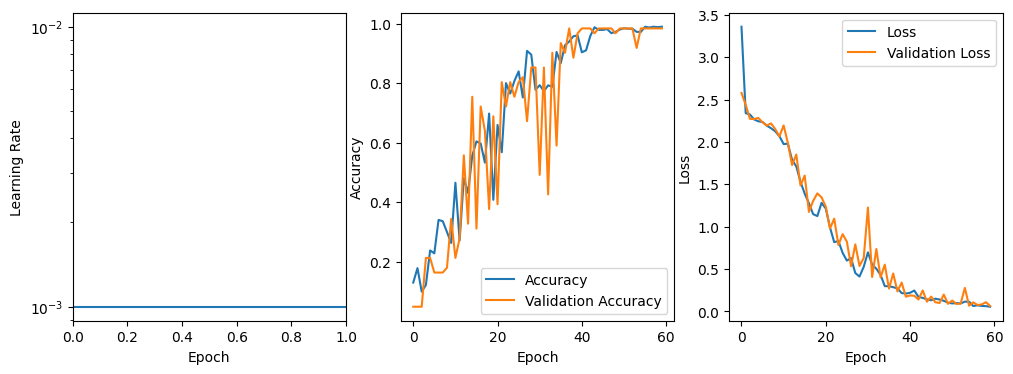

In [17]:
# We can view the results directly
plot_results(model_none)

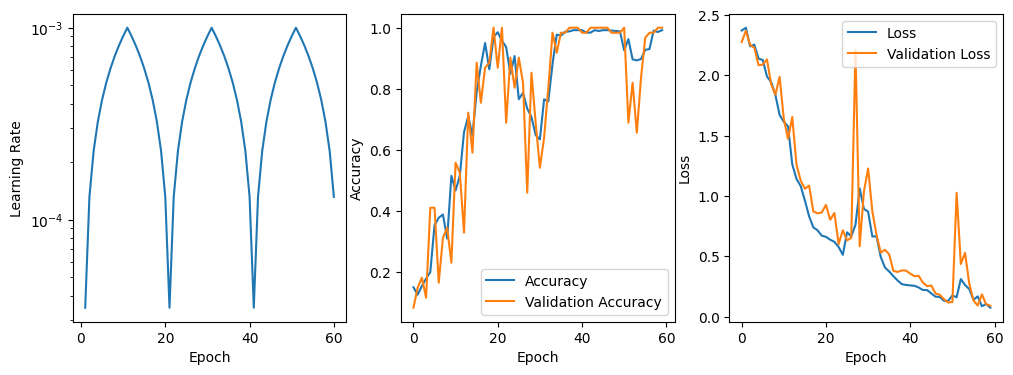

In [18]:
plot_results(model_clr, clr)

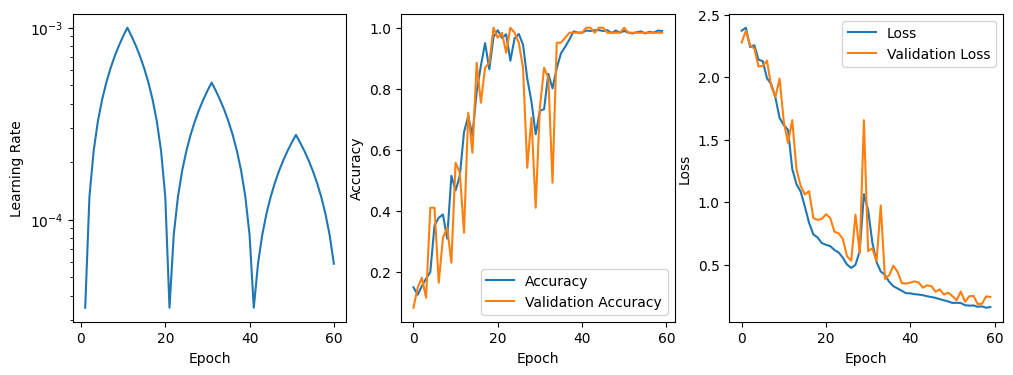

In [19]:
plot_results(model_clr2, clr2)

2D CNN
---

Load Data
***

In [20]:
# Let's build 2D "images" of these spectra with the same preprocessing as above
res = make_pgaa_images(
    transformer=GramianAngularField(method='difference'), 
    exclude_classes=['Carbon Powder', 'Phosphate Rock', 'Zircaloy'], 
    directory='./2d-dataset', 
    overwrite=True, 
    fmt='npy', 
    valid_range=valid_range, 
    renormalize=True,
    test_size=0.2,
    random_state=42
)

Transforming test set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.34it/s]


In [21]:
# We will use the label encoder for nicer visualization later on
encoder = res[-1]

Learning Rate Finder
***

In [62]:
# Let's use the CNNFactory in PyChemAuth to build a model for transfer learning

image_size = (valid_range[1]-valid_range[0], valid_range[1]-valid_range[0], 1)
n_classes = 10

cnn_builder = CNNFactory(
    name='mobilenet', # Name of the "fixed" base we will use (trained on imagenet)
    input_size=image_size,
    n_classes=n_classes,
    dim=2,
    cam=True,
    dropout=0.2
) 

In [24]:
# Let's look at a basic summary of this model
model = cnn_builder.build()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2631, 2631, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, 2631, 2631, 3)     3         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 2631, 2631, 3)     0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 2631, 2631, 3)     0         
 da)                                                             
                                                                 
 mobilenet_1.00_224 (Functi  (None, 82, 82, 1024)      3228864   
 onal)                                                           
                                                           

/home/nam4/anaconda3/envs/k3test/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


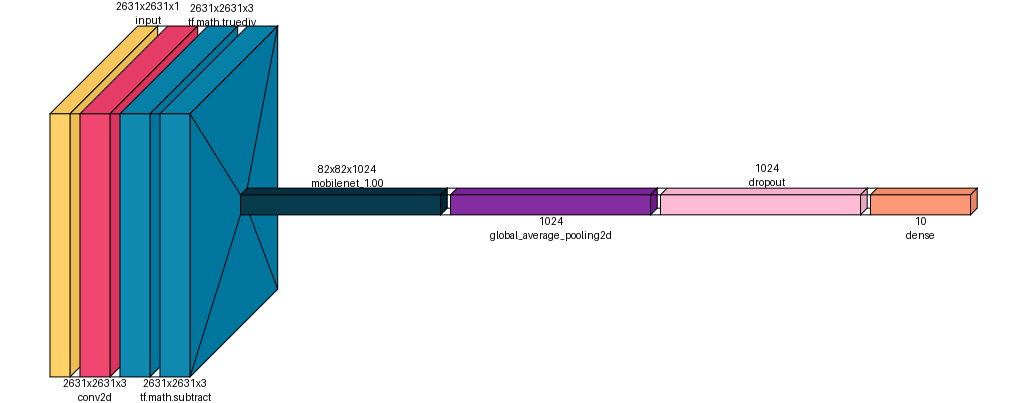

In [25]:
# We can also visualize the model another way
utils.NNTools.visualkeras(model, scale_xy=0.1, max_z=200)

In [26]:
# Now let's search for learning rate bounds
finder = utils.NNTools.find_learning_rate(
    cnn_builder.build(),
    pychemauth.utils.NNTools.build_loader('./2d-dataset/train/', batch_size=30),
    start_lr=1.0e-6,
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [

1/1 [==============================] - 5s 5s/step
Epoch 1/5
25/25 [==============================] - 232s 9s/step - loss: 3.5480 - accuracy: 0.0986 - sparse_categorical_accuracy: 0.0986
Epoch 2/5
25/25 [==============================] - 231s 9s/step - loss: 3.2099 - accuracy: 0.0866 - sparse_categorical_accuracy: 0.0866
Epoch 3/5
25/25 [==============================] - 232s 9s/step - loss: 4.0649 - accuracy: 0.1175 - sparse_categorical_accuracy: 0.1175
Epoch 4/5
25/25 [==============================] - 154s 6s/step - loss: 54.6713 - accuracy: 0.1315 - sparse_categorical_accuracy: 0.1315


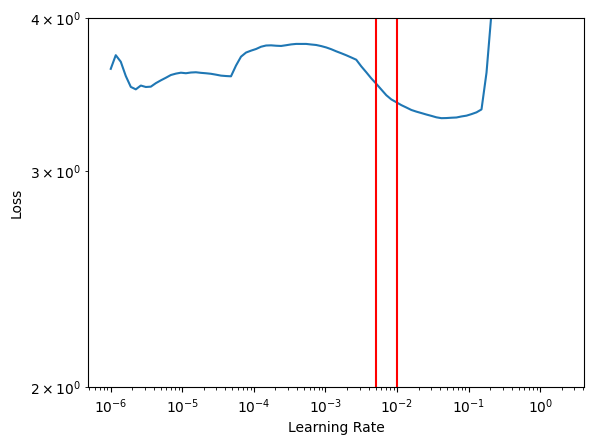

In [28]:
# "frac" can be adjusted to control the left / lower bound on the learning rate
# Adjust this until you are satisfied - we will use it next
frac = 0.9

ax = finder.plot()
ax.set_yscale('log')
ax.set_ylim(2,4)
for l_ in finder.estimate_clr(frac=frac):
    ax.axvline(l_, color='red')

Cyclical Learning Rates
***

In [30]:
def fit_model(image_size, finder, use_clr=False, wandb_project=None, mode='triangular'):
    """Convenient function to train models several times with different hyperparameters."""
    clr = utils.NNTools.CyclicalLearningRate(
        base_lr=finder.estimate_clr(frac=frac)[0],
        max_lr=finder.estimate_clr(frac=frac)[1],
        step_size=10, # 1/2 cycle every 10 epochs
        mode=mode,
    )

    model = cnn_builder.build()

    data_loader = NNTools.build_loader('./2d-dataset/train', batch_size=10, shuffle=True)
    
    model = utils.NNTools.train(
        model=model,
        data=data_loader, 
        fit_kwargs={
            'epochs': 60,
            'validation_data': NNTools.build_loader('./2d-dataset/test', batch_size=10),
            'shuffle': True,
            'callbacks': [clr] if use_clr else []
        },
        model_filename=None,
        history_filename=None,
        wandb_project=wandb_project,
        seed=42
    )
    
    return model, clr, data_loader

In [31]:
# Fit the model and track the training on WandB
model, clr, dl = fit_model(
    image_size,
    finder,
    use_clr=True, 
    wandb_project='cnn-2d-demo',
    mode='triangular2'
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [

1/1 [==============================] - 2s 2s/step


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


batch/accuracy,▁▁▂▂▄▃▃▄▅▆▇▇▇██▇██▇▅▅▆▆▇▇███████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▂▂▄▄▆▇█▇▆▅▄▂▂▁▂▂▃▃▄▄▄▄▃▂▂▁▁▁▂▂▂▂▃▃▂▂▂▂▁▁
batch/loss,███▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▃▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/sparse_categorical_accuracy,▁▁▂▂▄▃▃▄▅▆▇▇▇██▇██▇▅▅▆▆▇▇███████████████
epoch/accuracy,▁▁▁▂▃▃▄▄▅▆▆▇▇█████▇▆▆▆▆▇████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▂▂▄▄▆▇█▇▆▅▄▃▂▁▂▂▃▃▄▄▄▄▃▃▂▂▁▁▂▂▂▂▃▃▂▂▂▂▁▁
epoch/loss,███▇▇▇▆▆▄▄▄▃▃▃▃▂▂▂▂▂▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▂▃▃▄▄▅▆▆▇▇█████▇▆▆▆▆▇████████████████
epoch/val_accuracy,▁▂▁▃▂▃▂▅▃▆▇▆▇██▇██▅▆▆▇▄█████████████████


Epoch 1/30
25/25 [==============================] - 295s 12s/step - loss: 3.3279 - accuracy: 0.0799 - sparse_categorical_accuracy: 0.0799 - val_loss: 1.9743 - val_accuracy: 0.3279 - val_sparse_categorical_accuracy: 0.3279
Epoch 2/30
25/25 [==============================] - 291s 12s/step - loss: 2.7938 - accuracy: 0.1764 - sparse_categorical_accuracy: 0.1764 - val_loss: 2.1466 - val_accuracy: 0.1475 - val_sparse_categorical_accuracy: 0.1475
Epoch 3/30
25/25 [==============================] - 291s 12s/step - loss: 2.6212 - accuracy: 0.1971 - sparse_categorical_accuracy: 0.1971 - val_loss: 2.0730 - val_accuracy: 0.3770 - val_sparse_categorical_accuracy: 0.3770
Epoch 4/30
25/25 [==============================] - 292s 12s/step - loss: 2.6401 - accuracy: 0.2201 - sparse_categorical_accuracy: 0.2201 - val_loss: 2.4822 - val_accuracy: 0.1803 - val_sparse_categorical_accuracy: 0.1803
Epoch 5/30
25/25 [==============================] - 291s 12s/step - loss: 2.2099 - accuracy: 0.2543 - sparse_cat

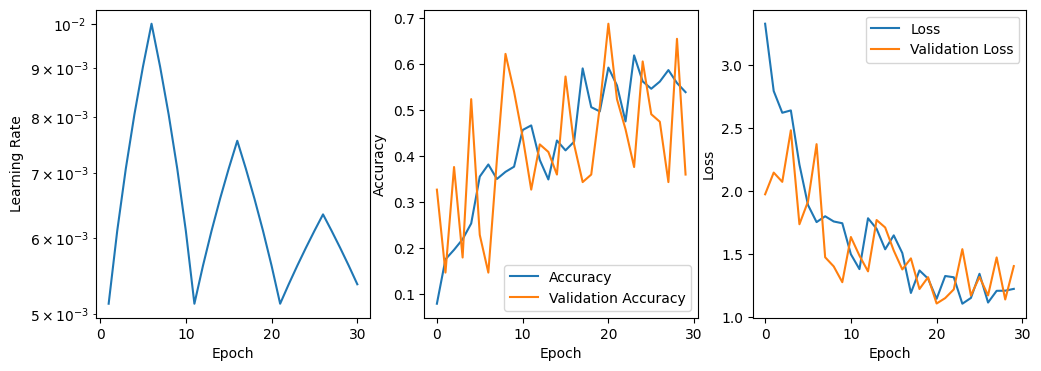

In [32]:
# Look at the results locally
plot_results(model, clr)

In [34]:
# Save the result to HuggingFace
_ = utils.HuggingFace.push_to_hub(
    model=model,
    namespace="mahynski", # Insert your own namespace here
    repo_name="2d-cnn-demo", # You can change the name if you like
    token="hf_*", # Insert your own token here
    private=False
)

In [5]:
# Load the model back from HuggingFace for comparison
hf_model = utils.HuggingFace.from_pretrained(
    model_id="mahynski/2d-cnn-demo",
)

2024-08-06 10:10:27.643136: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [36]:
# Confirm the models make the same predictions
preds = model.predict(utils.NNTools.build_loader('./2d-dataset/test', batch_size=10))
preds_hf = hf_model.predict(utils.NNTools.build_loader('./2d-dataset/test', batch_size=10))

np.allclose(preds, preds_hf)

7/7 [==============================] - 54s 7s/step


Explanations
---

Class Activation Maps (CAMs)
***

In [6]:
# We can use a CAM explainer to visually explain each prediction
explainer = CAM2D(style='hires')

In [7]:
# Load 2D data (and 1D for visualization reasons)
data_loader_2d = utils.NNTools.build_loader('./2d-dataset/test', batch_size=10)
data_loader_1d = utils.NNTools.build_loader('./1d-dataset/test', batch_size=10)

In [9]:
def explain(batch_idx, idx_in_batch):
    """Explain predictions from a certain batch."""
    X_batch, y_batch = data_loader_2d[batch_idx]
    X, y = X_batch[idx_in_batch], y_batch[idx_in_batch]

    X_batch, y_batch = data_loader_1d[batch_idx]
    X_line, y_line = X_batch[idx_in_batch], y_batch[idx_in_batch]
    
    explainer.visualize(
        image=X,
        model=hf_model,
        y=X_line.ravel(),
        x=np.arange(X_line.shape[0]),
        correct_label=encoder.inverse_transform([y])[0],
        origin='upper',
        encoder=encoder
    )

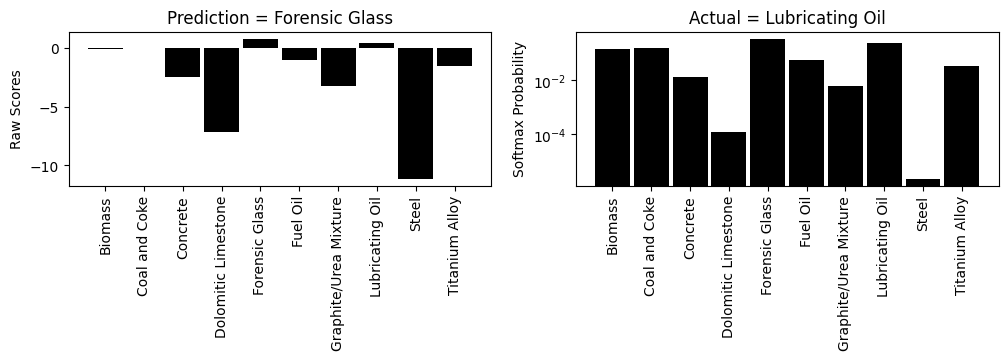

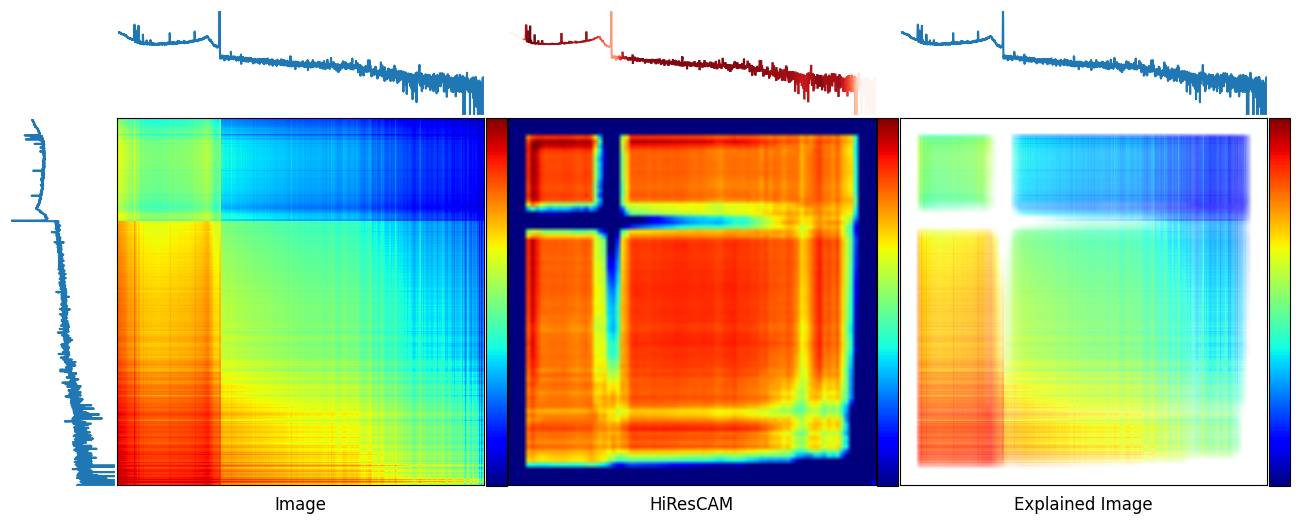

In [77]:
# Incorrect, but close guess
explain(0, 0)

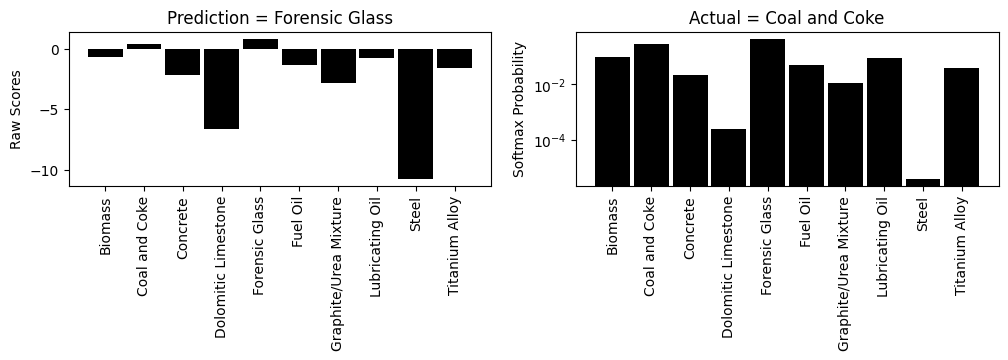

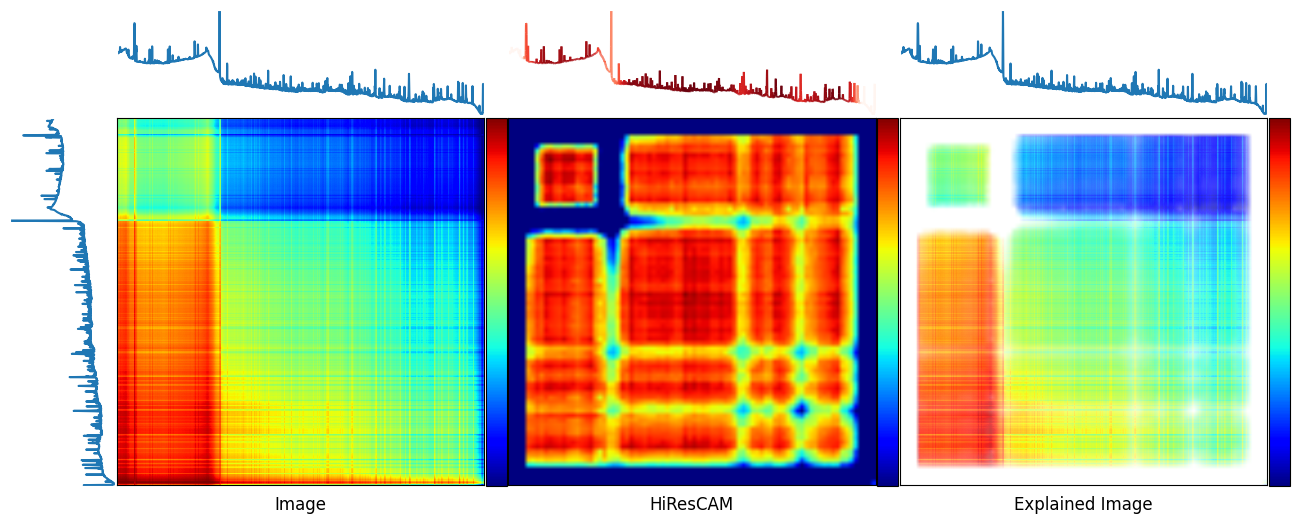

In [48]:
# Incorrect, but close guess again
explain(0, 1)

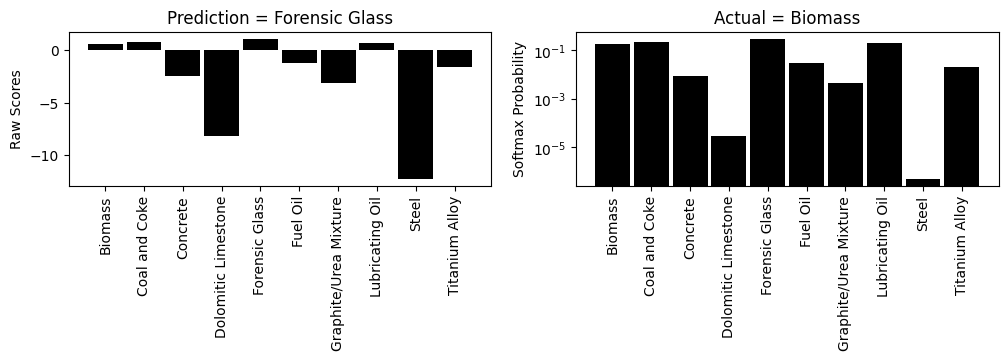

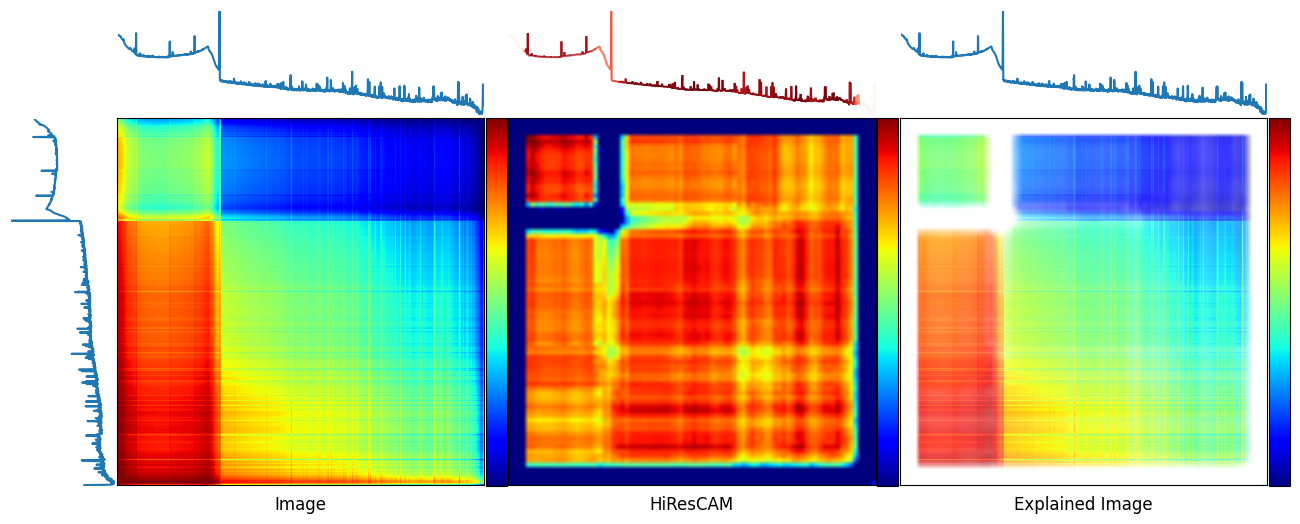

In [49]:
explain(0, 2)

Manual Inspection in 1D
***

In [8]:
# Sometimes we might want to take a closer look and interactively explore an explanation, especially in 1D
# Here is a way to do that using Bokeh for interactive visualization.

importances = explainer.importances(
    image=data_loader_2d[0][0][0],
    model=hf_model,
    symmetrize=True,
    dim=1, # Get a 1D summary of the 2D explanation
    series_summary='mean'
)

peaks, _ = data_loader_1d[0]

In [9]:
from bokeh.io import output_notebook
output_notebook()

bokeh_color_spectrum(
    y=peaks[0],
    x=np.arange(peaks[0].shape[0]),
    importance_values=importances
)

Loading BokehJS ...

SHAP
***

This explanation relies on the "partition" explainer by "bluring" pixels to create "super pixels".  See [here](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html) for more details.

In [63]:
# Remember the model's properties - specifically, the "image" shape coming out of the pretrained CNN base
hf_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2631, 2631, 1)]   0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2631, 2631, 3)     3         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 2631, 2631, 3)     0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 2631, 2631, 3)     0         
 mbda)                                                           
                                                                 
 mobilenet_1.00_224 (Functi  (None, 82, 82, 1024)      3228864   
 onal)                                                           
                                                           

In [58]:
# def f(x):
#     return hf_model(x.copy())

# Blur the input to about the same size as the output from the CNN base (here: (82, 82))
blur_size = hf_model.layers[-3].input_shape[1:3]

# Define a masker that is used to mask out partitions of the input image creating partitions.
# This is not strictly necessary (size can be arbitrary) but this way we can more fairly compare these
# explanations with those from CAM.
masker = shap.maskers.Image(f"blur{blur_size}", image_size)

# create an explainer with model and image masker
explainer = shap.Explainer(
    hf_model.predict, # f
    masker=masker, 
    output_names=encoder.classes_,
    algorithm="partition"
)

In [ ]:
# Let's select the same points we did with CAM
X, y = data_loader_2d[0]

In [59]:
# The correct answers
encoder.inverse_transform(y[:3])

array(['Lubricating Oil', 'Coal and Coke', 'Biomass'], dtype=object)

In [60]:
# Explain these first 3 predictions - the "argsort" is a simple way to retrieve the top 4 most likely predictions.
# Conveniently, these are provided with SHAP.  Although we can compute similar CAM maps, this is not typically done
# and PyChemAuth is not configured for this at the moment.
shap_values = explainer(
    X[:3], 
    max_evals=200, # This controls how "fine-grained" the resulting map is
    outputs=shap.Explanation.argsort.flip[:4]
)

  0%|          | 0/198 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███████████████████████████████████████████████████████▎                                                                                                              | 1/3 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [09:52<00:00, 148.28s/it]

  0%|          | 0/198 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [14:50, 296.94s/it]                                                                                                                                                                          


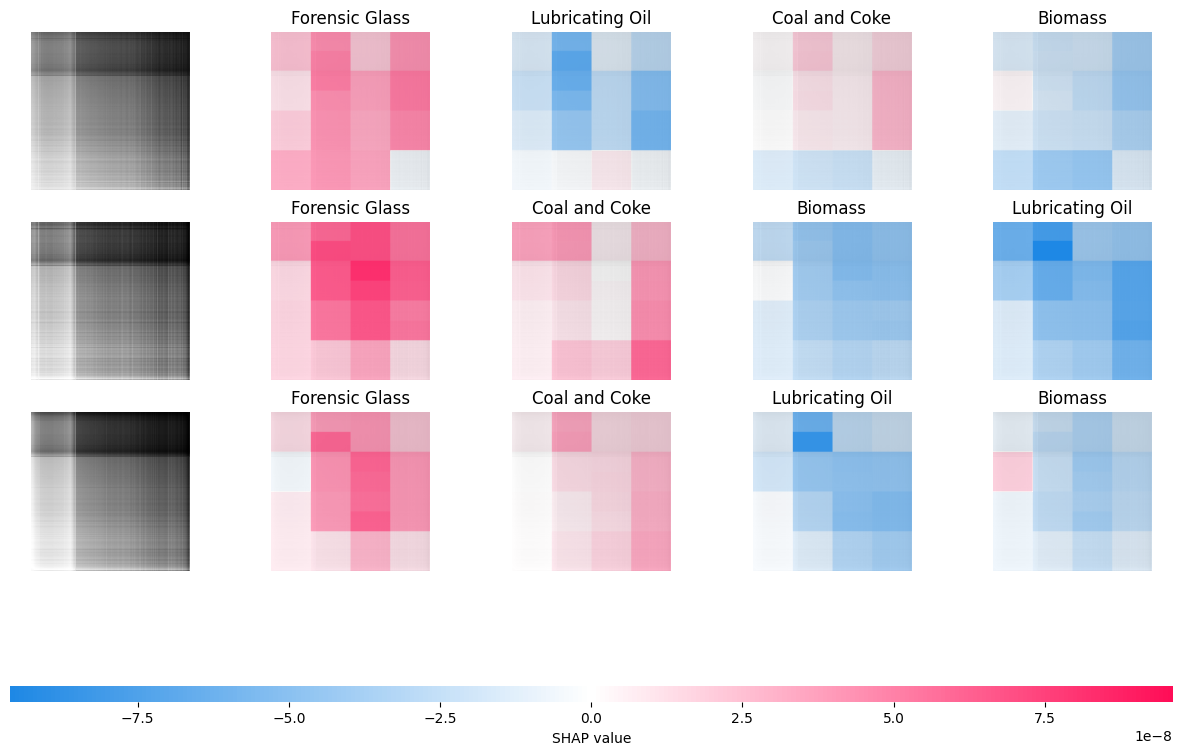

In [70]:
shap.image_plot(shap_values)